# Warsztaty Python w Data Science

---
## Text Mining - część 1 z 3  

- ### Tokenizacja
- ### Statystyka
- ### Prosta Lemmatyzacja
- ### TF-IDF

https://github.com/MichalKorzycki/WarsztatPythonDataScience

https://drive.google.com/drive/folders/1HR8VCledCwD7BRMO1AucUM3x7cYC-AVT?usp=sharing

---
# Zadanie 1.
Wyciągnąć z _*kilku*_ ogłoszeń ich tytuły i treści

In [ ]:
import scrapy
import datetime
import pandas as pd
import scrapy.crawler as crawler
from bs4 import BeautifulSoup
from scrapy.exporters import CsvItemExporter
from scrapy.crawler import CrawlerProcess

url_results = []
desc_results = []
title_results = []


class GumtreeApartmentsSpider(scrapy.Spider):
    name = 'gumtreeapartmentsspider'
    start_urls = [ 
    
        'https://www.gumtree.pl/s-mieszkania-i-domy-sprzedam-i-kupie/mazowieckie/page-'+str(i)+'/v1c9073l3200001p'+str(i)  for i in range(2, 11)
        ]
    start_urls.append(
        'https://www.gumtree.pl/s-mieszkania-i-domy-sprzedam-i-kupie/mazowieckie/v1c9073l3200001p1'
    )
    found_apartments = []
   
    custom_settings = {
        'DOWNLOAD_DELAY': '2.0',
        'ROBOTSTXT_OBEY': True,
        'AUTOTHROTTLE_ENABLED': True,
        'USER_AGENT': 'My Bot (email@myemail.com)'
    }

    top_url = 'https://www.gumtree.pl'
    def parse(self, response):
        self.logger.info('Got successful response from {}'.format(response.url))
        soup = BeautifulSoup(response.body, 'lxml')
        titles = [flat.next_element for flat in soup.find_all('a', class_ = "href-link tile-title-text")] 
        links = ['https://www.gumtree.pl' + link.get('href')
                for link in soup.find_all('a', class_ ="href-link tile-title-text")]
            
        for item_url in links:
            yield scrapy.Request(item_url, self.parse_item)
        
    def parse_item(self, response): 
        self.logger.info('Got successful response from {}'.format(response.url))
        soup = BeautifulSoup(response.body, 'lxml')
        title = soup.find('span', class_ ="myAdTitle")
        description = soup.find('div', class_ ="description")
        item = {
            "url": response.url,
            "title": title,
            "description": description,
        }

        url_results.append(response.url)
        desc_results.append(description)
        title_results.append(title)
        
    def spider_closed(self, spider):
        spider.logger.info('Spider closed: %s', spider.name)
        
        df = pd.Dataframe({
            "title": title_results,
            "description": desc_results,
            "url": url_results
        })
        fname = f"gumtree-{now}.csv"
        print(fname)
        df.to_csv(fname)

In [ ]:
process = CrawlerProcess()
process.crawl(GumtreeApartmentsSpider)
process.start()

In [ ]:
df = pd.DataFrame({
            "title": title_results,
            "description": desc_results,
            "url": url_results
        })

In [ ]:
now = datetime.datetime.now().strftime("%Y-%m-%d")
fname = f"data\gumtree-{now}.csv"
print(fname)
df.to_csv(fname, sep="|")

---
# Tokenizacja

In [1]:
import pandas as pd

data = pd.read_csv('data\gumtree-2021-03-09.csv', sep='|')
data.set_index('Unnamed: 0')

,title,description,url
Unnamed: 0,,,
0,"<span class=""myAdTitle"">Kawalerka Geodetów Och...","<div class=""description"" data-phone-mask=""fals...",https://www.gumtree.pl/a-mieszkania-i-domy-spr...
1,"<span class=""myAdTitle"">Mieszkanie 2 pokojowe ...","<div class=""description"" data-phone-mask=""fals...",https://www.gumtree.pl/a-mieszkania-i-domy-spr...
2,"<span class=""myAdTitle"">Wyjątkowa Inwestycja N...","<div class=""description"" data-phone-mask=""fals...",https://www.gumtree.pl/a-mieszkania-i-domy-spr...
3,"<span class=""myAdTitle"">5 pokoi z ogródkiem, n...","<div class=""description"" data-phone-mask=""fals...",https://www.gumtree.pl/a-mieszkania-i-domy-spr...
4,"<span class=""myAdTitle"">2-pokojowe mieszkanie ...","<div class=""description"" data-phone-mask=""fals...",https://www.gumtree.pl/a-mieszkania-i-domy-spr...
...,...,...,...
219,"<span class=""myAdTitle"">Gotowe do odbioru 3 po...","<div class=""description"" data-phone-mask=""fals...",https://www.gumtree.pl/a-mieszkania-i-domy-spr...
220,"<span class=""myAdTitle"">Stary Mokotów, blisko ...","<div class=""description"" data-phone-mask=""fals...",https://www.gumtree.pl/a-mieszkania-i-domy-spr...
221,"<span class=""myAdTitle"">Przestronne mieszkanie...","<div class=""description"" data-phone-mask=""fals...",https://www.gumtree.pl/a-mieszkania-i-domy-spr...


In [36]:
opis = data['description'][0]
opis

'<div class="description" data-phone-mask="false"><span class="pre" style="font-family: inherit; white-space: pre-wrap;"><p>Na sprzedaż piękna kawalerka o powierzchni 24 m2 na ostatnim piętrze 10 piętrowego bloku z oknem wychodzącym na spokojną stronę osiedla. Bardzo dobrze skomunikowane z centrum (tramwaje ,autobusy).</p><p>W pobliżu znajduje się dobra infrastruktura: sklepy, apteka, szkoła, targowisko ( hala Banacha),oraz park szczęśliwicki (5 minut na piechotę).Mieszkanie słoneczne i bardzo ustawne ,budynek po wymianie windy i elektryki w częściach wspólnych.</p><p>Serdecznie zapraszamy do kontaktu.</p></span></div>'

In [37]:
import re

def no_tags(s):
    return re.sub(r'<[^<]+?>','',s)

opis = no_tags(opis)
opis

'Na sprzedaż piękna kawalerka o powierzchni 24 m2 na ostatnim piętrze 10 piętrowego bloku z oknem wychodzącym na spokojną stronę osiedla. Bardzo dobrze skomunikowane z centrum (tramwaje ,autobusy).W pobliżu znajduje się dobra infrastruktura: sklepy, apteka, szkoła, targowisko ( hala Banacha),oraz park szczęśliwicki (5 minut na piechotę).Mieszkanie słoneczne i bardzo ustawne ,budynek po wymianie windy i elektryki w częściach wspólnych.Serdecznie zapraszamy do kontaktu.'

In [38]:
import re

tokenizer = re.compile(r'[^ąąćęńłóóśśżżź\w]+')
tokenized = tokenizer.split(opis)
str(tokenized)

"['Na', 'sprzedaż', 'piękna', 'kawalerka', 'o', 'powierzchni', '24', 'm2', 'na', 'ostatnim', 'piętrze', '10', 'piętrowego', 'bloku', 'z', 'oknem', 'wychodzącym', 'na', 'spokojną', 'stronę', 'osiedla', 'Bardzo', 'dobrze', 'skomunikowane', 'z', 'centrum', 'tramwaje', 'autobusy', 'W', 'pobliżu', 'znajduje', 'się', 'dobra', 'infrastruktura', 'sklepy', 'apteka', 'szkoła', 'targowisko', 'hala', 'Banacha', 'oraz', 'park', 'szczęśliwicki', '5', 'minut', 'na', 'piechotę', 'Mieszkanie', 'słoneczne', 'i', 'bardzo', 'ustawne', 'budynek', 'po', 'wymianie', 'windy', 'i', 'elektryki', 'w', 'częściach', 'wspólnych', 'Serdecznie', 'zapraszamy', 'do', 'kontaktu', '']"

In [39]:
tokenized = [ x.lower() for x in tokenized ]
str(tokenized)

"['na', 'sprzedaż', 'piękna', 'kawalerka', 'o', 'powierzchni', '24', 'm2', 'na', 'ostatnim', 'piętrze', '10', 'piętrowego', 'bloku', 'z', 'oknem', 'wychodzącym', 'na', 'spokojną', 'stronę', 'osiedla', 'bardzo', 'dobrze', 'skomunikowane', 'z', 'centrum', 'tramwaje', 'autobusy', 'w', 'pobliżu', 'znajduje', 'się', 'dobra', 'infrastruktura', 'sklepy', 'apteka', 'szkoła', 'targowisko', 'hala', 'banacha', 'oraz', 'park', 'szczęśliwicki', '5', 'minut', 'na', 'piechotę', 'mieszkanie', 'słoneczne', 'i', 'bardzo', 'ustawne', 'budynek', 'po', 'wymianie', 'windy', 'i', 'elektryki', 'w', 'częściach', 'wspólnych', 'serdecznie', 'zapraszamy', 'do', 'kontaktu', '']"

In [40]:
def preprocessing(opis):
    opis = no_tags(opis)
    tokenized = tokenizer.split(opis)
    l = list(tokenized)
    l = [ x.lower() for x in l ]
    return l

In [41]:
corpus=[]
n=4
for row in data.iterrows():
    opis = row[1][2]
    l = preprocessing(opis)
    corpus.append(l)
    n-=1
    if n==0: break

for opis in corpus:
    print(opis)
    print()

['na', 'sprzedaż', 'piękna', 'kawalerka', 'o', 'powierzchni', '24', 'm2', 'na', 'ostatnim', 'piętrze', '10', 'piętrowego', 'bloku', 'z', 'oknem', 'wychodzącym', 'na', 'spokojną', 'stronę', 'osiedla', 'bardzo', 'dobrze', 'skomunikowane', 'z', 'centrum', 'tramwaje', 'autobusy', 'w', 'pobliżu', 'znajduje', 'się', 'dobra', 'infrastruktura', 'sklepy', 'apteka', 'szkoła', 'targowisko', 'hala', 'banacha', 'oraz', 'park', 'szczęśliwicki', '5', 'minut', 'na', 'piechotę', 'mieszkanie', 'słoneczne', 'i', 'bardzo', 'ustawne', 'budynek', 'po', 'wymianie', 'windy', 'i', 'elektryki', 'w', 'częściach', 'wspólnych', 'serdecznie', 'zapraszamy', 'do', 'kontaktu', '']

['mieszkanie', 'dwupokojowe', 'własnościowe', 'z', '1971', 'r', 'na', 'pierwszym', 'piętrze', 'w', 'bloku', '4', 'piętrowym', 'z', 'ładnym', 'widokiem', 'na', 'podwórko', 'ciche', 'duże', 'podwórko', 'i', 'sporo', 'miejsc', 'parkingowych', 'salon', 'z', 'aneksem', 'kuchennym', '22', 'mkw', 'sypialnia', '9', 'mkw', 'łazienka', 'i', 'korytarz

In [43]:
corpus = []
for row in data.iterrows():
    opis = row[1][2]
    if type(opis) == str:
        l = preprocessing(opis)
        corpus.append(l)

    
print(f"Mamy tekstów: {len(corpus)}")

Mamy tekstów: 222


In [44]:
all_words = []
for t in corpus:
    all_words += t
 
print(f"Mamy {len(all_words)} wyrazów")
all_words[:15]

Mamy 46696 wyrazów


['na',
 'sprzedaż',
 'piękna',
 'kawalerka',
 'o',
 'powierzchni',
 '24',
 'm2',
 'na',
 'ostatnim',
 'piętrze',
 '10',
 'piętrowego',
 'bloku',
 'z']

In [45]:
counter = {}

for w in all_words:
    counter[w] = counter.get(w,0)+1

print(f"Mamy {len(counter.keys())} RÓŻNYCH wyrazów")

Mamy 4593 RÓŻNYCH wyrazów


In [46]:
counted_words= [ (word,cnt) for word,cnt in counter.items() ]
counted_words[:4]

[('na', 1048), ('sprzedaż', 15), ('piękna', 5), ('kawalerka', 2)]

In [47]:
from operator import itemgetter

counted_words.sort(key=itemgetter(1), reverse=True)
counted_words[:20]

[('w', 1509),
 ('i', 1293),
 ('na', 1048),
 ('z', 1022),
 ('do', 831),
 ('się', 457),
 ('mieszkania', 445),
 ('pln', 328),
 ('inwestycji', 313),
 ('również', 300),
 ('oraz', 297),
 ('od', 291),
 ('premium', 275),
 ('estates', 274),
 ('maryla', 274),
 ('dla', 267),
 ('jest', 257),
 ('zapraszamy', 255),
 ('inwestycja', 234),
 ('oferty', 231)]

In [48]:
counted_words[-20:]

[('kanalizacujna', 1),
 ('zlikwidowane', 1),
 ('piecyki', 1),
 ('zmiany', 1),
 ('warto', 1),
 ('powiększyć', 1),
 ('najmniejszy', 1),
 ('ścianki', 1),
 ('działowe', 1),
 ('zakupić', 1),
 ('kredytplan', 1),
 ('zamieszczony', 1),
 ('chartaker', 1),
 ('poglądowyzapraszam', 1),
 ('prezentacji', 1),
 ('nietuzinkowej', 1),
 ('dostrzegą', 1),
 ('zwłaszcza', 1),
 ('lubujące', 1),
 ('klimacie', 1)]

In [49]:
counts = [ x[1] for x in counted_words ]
len(counts)

4593

In [50]:
sum(counts)

46696

In [51]:
sum(counts[:120])

23292

In [53]:
counted_words[110:130]

[('sportów', 89),
 ('wyższych', 88),
 ('teren', 87),
 ('będzie', 86),
 ('zabaw', 86),
 ('30', 86),
 ('terenie', 85),
 ('duże', 83),
 ('dojazdem', 82),
 ('rozwój', 82),
 ('natury', 82),
 ('pok', 82),
 ('p', 82),
 ('minut', 81),
 ('będą', 81),
 ('dynamiczny', 81),
 ('ceniących', 81),
 ('myślą', 81),
 ('lokalizację', 78),
 ('ul', 77)]

In [54]:
count_df = pd.DataFrame(counts[:120])
count_df

,0
0,1509
1,1293
2,1048
3,1022
4,831
...,...
115,86
116,85
117,83
118,82


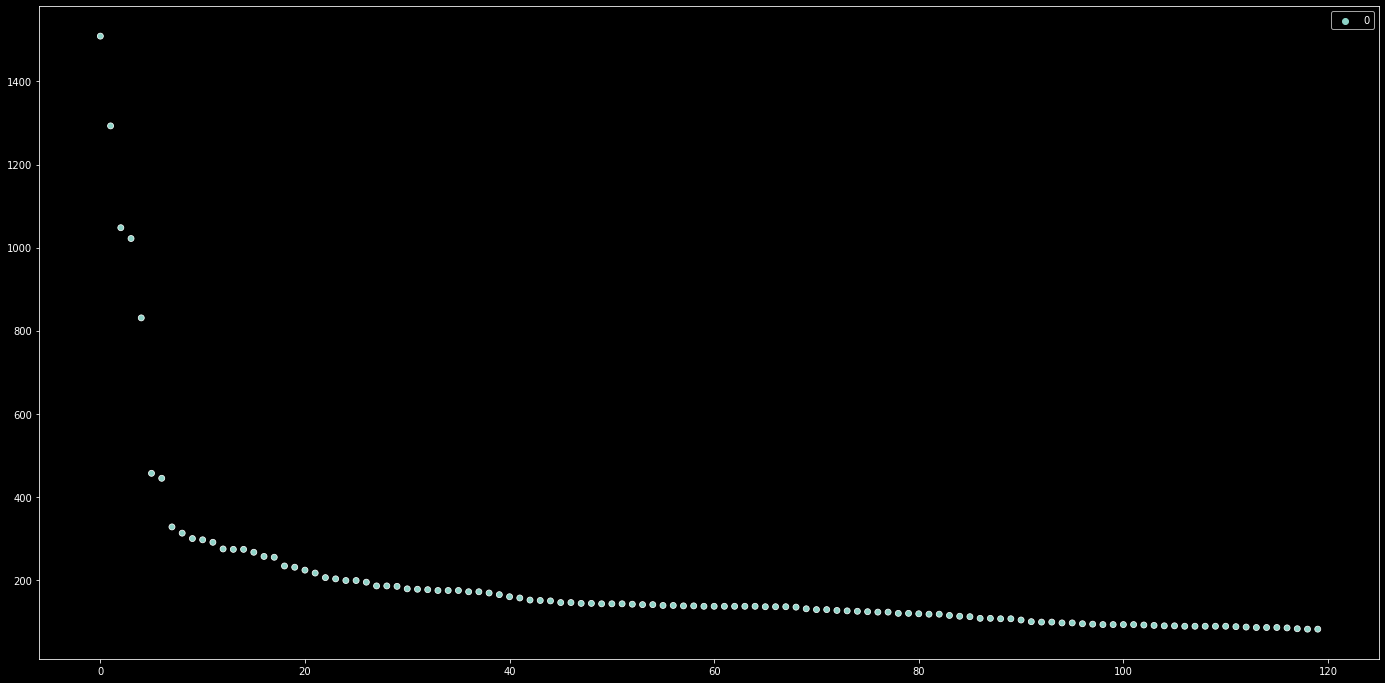

In [55]:
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
from pandas.plotting import register_matplotlib_converters
register_matplotlib_converters()
import matplotlib.dates as mdates

plt.figure(figsize=(24,12))
plt.style.use("dark_background")

chart = sns.scatterplot(
                     color='purple', 
                     data=count_df
                    )

---
# Lematyzacja

## _Lematyzacja_ - sprowadzenie wyrazu do formy podstawowej tak aby różne formy tego wyrazu (*kot*, *kota*, *kotu*) były rozpatrywane jako ten sam wyraz (*kot*) 

https://sjp.pl/
    
Słownik SJP.PL
Słownik języka polskiego, ortograficzny, wyrazów obcych i słownik do gier w jednym.

Słownik jest rozwijany z myślą o zastosowaniu do sprawdzania pisowni w programach open-source, do gier słownych (np. literaki) i do użytku online jako kilka rodzajów słowników w jednym.

Redakcją słownika zajmują się hobbyści.

Słownik jest udostępniany na otwartych licencjach (różnych w zależności od wersji).

In [19]:
import gzip
import sys
import re

f = gzip.open('data/odm.txt.gz', 'rt', encoding='utf-8')
dictionary = {}

for x in f:
    t = x.strip().split(',')
    tt = [ x.strip().lower() for x in t]
    for w in tt[1:]: 
        dictionary[w]=tt[0]


In [20]:
def lematize(w):
    return dictionary.get(w,w)

In [21]:
corpusl = [[ lematize(x) for x in l ] for l in corpus]
for opis in corpusl[:4]:
    print(opis)
    print()

['na', 'sprzedaż', 'piękny', 'kawalerka', 'o', 'powierzchnia', '24', 'm2', 'na', 'ostatni', 'piętro', '10', 'piętrowy', 'blok', 'z', 'okno', 'wychodzić', 'na', 'spokojny', 'strona', 'osiedle', 'bardzo', 'dobry', 'skomunikować', 'z', 'centrum', 'tramwaj', 'autobus', 'w', 'pobliże', 'znajdywać', 'siebie', 'dobry', 'infrastruktura', 'sklep', 'apteka', 'szkoła', 'targowisko', 'hala', 'banach', 'oraz', 'park', 'szczęśliwicki', '5', 'minuta', 'na', 'piechota', 'mieszkać', 'słoneczny', 'i', 'bardzo', 'ustawny', 'budynek', 'po', 'wymian', 'winda', 'i', 'elektryk', 'w', 'część', 'wspólny', 'serdeczny', 'zapraszać', 'do', 'kontakt', '']

['mieszkać', 'dwupokojowy', 'własnościowy', 'z', '1971', 'r', 'na', 'pierwszy', 'piętro', 'w', 'blok', '4', 'piętrowy', 'z', 'ładny', 'widok', 'na', 'podwórko', 'cichy', 'duży', 'podwórko', 'i', 'spory', 'miejsce', 'parkingowy', 'salon', 'z', 'aneks', 'kuchenny', '22', 'mkw', 'sypialnia', '9', 'mkw', 'łazienka', 'i', 'korytarz', 'mieszkać', 'mój', 'mały', 'balko

In [22]:
all_words = []
for t in corpusl:
    all_words += t
 
print(f"Mamy {len(all_words)} wyrazów")
all_words[:15]

Mamy 46696 wyrazów


['na',
 'sprzedaż',
 'piękny',
 'kawalerka',
 'o',
 'powierzchnia',
 '24',
 'm2',
 'na',
 'ostatni',
 'piętro',
 '10',
 'piętrowy',
 'blok',
 'z']

In [23]:
counter = {}

for w in all_words:
    counter[w] = counter.get(w,0)+1

print(f"Mamy {len(counter.keys())} RÓŻNYCH wyrazów")

Mamy 3139 RÓŻNYCH wyrazów


In [24]:
from operator import itemgetter
counted_words= [ (word,cnt) for word,cnt in counter.items() ]
counted_words.sort(key=itemgetter(1), reverse=True)
counted_words[:20]

[('w', 1509),
 ('i', 1293),
 ('na', 1048),
 ('z', 1022),
 ('do', 831),
 ('inwestycja', 553),
 ('być', 495),
 ('siebie', 494),
 ('mieszkanie', 469),
 ('miejsce', 440),
 ('oferta', 434),
 ('warszawa', 376),
 ('pln', 328),
 ('zapraszać', 310),
 ('ten', 309),
 ('również', 300),
 ('oraz', 297),
 ('oda', 291),
 ('premium', 275),
 ('estates', 274)]

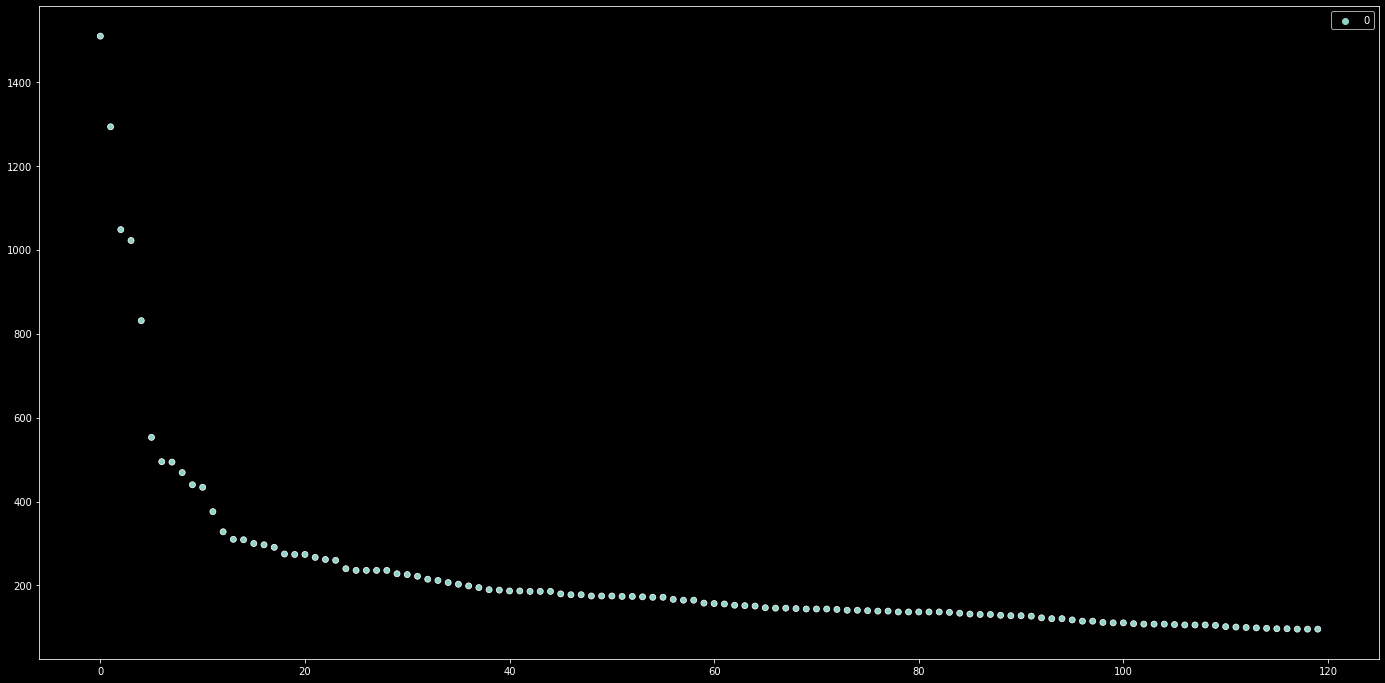

In [34]:
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
from pandas.plotting import register_matplotlib_converters
register_matplotlib_converters()
import matplotlib.dates as mdates

counts = [ x[1] for x in counted_words ]
count_df = pd.DataFrame(counts[:120])
count_df

plt.figure(figsize=(24,12))
plt.style.use("dark_background")

chart = sns.scatterplot(
        color='purple', 
        data=count_df
        )

---
## Metryka TF-IDF
ile razy występuję wyraz *i* w tekście *j*
$${n}_{ij}$$ 
 ### Term Frequency (TF)
 
 $${tf}_{ij} = \frac{{n}_{ij}}{\sum{k}{{n}_{ik}}}$$
 
 W tekście *j* sprawdzamy ile proporcjonalnie do całości występuje wyraz *i*
### Inverted Document Frequency (IDF)

 $$idf_i = log \frac{|D|}{ \{ d: n_i \in d \}}$$
 
 licznik - liczba dokumentów
 
 mianownik - liczba dokumentów w którym wystapił wyraz *i*-ty 

ile razy występuję wyraz *i* w tekście *j*

$${n}_{ij}$$ 

 ### Term Frequency (TF)
 
 $${tf}_{ij} = \frac{{n}_{ij}}{\sum{k}{{n}_{ik}}}$$
 
 W tekście *j* sprawdzamy ile proporcjonalnie do całości występuje wyraz *i*

### Inverted Document Frequency (IDF)

 $$idf_i = log \frac{|D|}{ \{ d: n_i \in d \}}$$
 
 licznik - liczba dokumentów
 
 mianownik - liczba dokumentów w którym wystapił wyraz *i*-ty 

---
## Zadanie 1

Podać wyrazy z korpusu o największym `TF-IDF` z pominięciem wyrazów które wystepują _**raz**_.